# Fire and smoke detection with Keras and Deep Learning

### Downloading the dataset

In [2]:
!wget https://pis-datasets.s3.us-east-2.amazonaws.com/Robbery_Accident_Fire_Database.zip
!unzip -qq Robbery_Accident_Fire_Database.zip

--2021-06-17 21:52:51--  https://pis-datasets.s3.us-east-2.amazonaws.com/Robbery_Accident_Fire_Database.zip
Resolving pis-datasets.s3.us-east-2.amazonaws.com (pis-datasets.s3.us-east-2.amazonaws.com)... 52.219.97.114
Connecting to pis-datasets.s3.us-east-2.amazonaws.com (pis-datasets.s3.us-east-2.amazonaws.com)|52.219.97.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1035702869 (988M) [application/zip]
Saving to: ‘Robbery_Accident_Fire_Database.zip’

Robbery_Accident_Fi 100%[===================>] 987.72M  43.1MB/s    in 39s     

2021-06-17 21:53:30 (25.1 MB/s) - ‘Robbery_Accident_Fire_Database.zip’ saved [1035702869/1035702869]



In [3]:
%%bash 
sh prune.sh

In [4]:
!wget https://pis-datasets.s3.us-east-2.amazonaws.com/spatial_envelope_256x256_static_8outdoorcategories.zip
!unzip -qq spatial_envelope_256x256_static_8outdoorcategories.zip

--2021-06-17 21:53:39--  https://pis-datasets.s3.us-east-2.amazonaws.com/spatial_envelope_256x256_static_8outdoorcategories.zip
Resolving pis-datasets.s3.us-east-2.amazonaws.com (pis-datasets.s3.us-east-2.amazonaws.com)... 52.219.84.184
Connecting to pis-datasets.s3.us-east-2.amazonaws.com (pis-datasets.s3.us-east-2.amazonaws.com)|52.219.84.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135033638 (129M) [application/zip]
Saving to: ‘spatial_envelope_256x256_static_8outdoorcategories.zip’

spatial_envelope_25 100%[===================>] 128.78M  38.4MB/s    in 3.4s    

2021-06-17 21:53:43 (38.4 MB/s) - ‘spatial_envelope_256x256_static_8outdoorcategories.zip’ saved [135033638/135033638]



### Import Packages

In [5]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pyimagesearch.learningratefinder import LearningRateFinder
from tensorflow.keras.models import load_model
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import random
import cv2
import sys
import os

### Our configuration file

In [6]:
class Config:
    # initialize the path to the fire and non-fire dataset directories
    FIRE_PATH = os.path.sep.join(["Robbery_Accident_Fire_Database2",
        "Fire"])
    NON_FIRE_PATH = "spatial_envelope_256x256_static_8outdoorcategories"
    
    # initialize the class labels in the dataset
    CLASSES = ["Non-Fire", "Fire"]

    # define the size of the training and testing split
    TRAIN_SPLIT = 0.75
    TEST_SPLIT = 0.25
    
    # define the initial learning rate, batch size, and number of epochs
    INIT_LR = 1e-2
    BATCH_SIZE = 64
    NUM_EPOCHS = 50

    # set the path to the serialized model after training
    MODEL_PATH = os.path.sep.join(["output", "fire_detection.model"])
    
    # define the path to the output learning rate finder plot and
    # training history plot
    LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
    TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])

    # define the path to the output directory that will store our final
    # output with labels/annotations along with the number of images to
    # sample
    OUTPUT_IMAGE_PATH = os.path.sep.join(["output", "examples"])
    SAMPLE_SIZE = 50

# initialize the configuration object
config = Config()

### Implementing our fire detection Convolutional Neural Network

In [7]:
class FireDetectionNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# CONV => RELU => POOL
		model.add(SeparableConv2D(16, (7, 7), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# CONV => RELU => POOL
		model.add(SeparableConv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# (CONV => RELU) * 2 => POOL
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# second set of FC => RELU layers
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

### Creating our training script

In [8]:
def load_dataset(datasetPath):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image and resize it to be a fixed 128x128 pixels,
		# ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.resize(image, (128, 128))

		# add the image to the data lists
		data.append(image)

	# return the data list as a NumPy array
	return np.array(data, dtype="float32")

In [9]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
   "lr_find": 0
}

In [10]:
# load the fire and non-fire images
print("[INFO] loading data...")
fireData = load_dataset(config.FIRE_PATH)
nonFireData = load_dataset(config.NON_FIRE_PATH)

# construct the class labels for the data
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))

# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])
data /= 255

[INFO] loading data...


In [11]:
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels = to_categorical(labels, num_classes=2)

# calculate the total number of images in each class and
# initialize a dictionary to store the class weights
classTotals = labels.sum(axis=0)
classWeight = dict()

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]


# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=config.TEST_SPLIT, random_state=42)

In [12]:
# initialize the training data augmentation object
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=config.INIT_LR, momentum=0.9,
	decay=config.INIT_LR / config.NUM_EPOCHS)
model = FireDetectionNet.build(width=128, height=128, depth=3,
	classes=2)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs
if args["lr_find"] > 0:
	# initialize the learning rate finder and then train with learning
	# rates ranging from 1e-10 to 1e+1
	print("[INFO] finding learning rate...")
	lrf = LearningRateFinder(model)
	lrf.find(
		aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
		1e-10, 1e+1,
		stepsPerEpoch=np.ceil((trainX.shape[0] / float(config.BATCH_SIZE))),
		epochs=20,
		batchSize=config.BATCH_SIZE,
		classWeight=classWeight)

	# plot the loss for the various learning rates and save the
	# resulting plot to disk
	lrf.plot_loss()
	plt.savefig(config.LRFIND_PLOT_PATH)

	# gracefully exit the script so we can adjust our learning rates
	# in the config and then train the network for our full set of
	# epochs
	print("[INFO] learning rate finder complete")
	print("[INFO] examine plot and adjust learning rates before training")

In [14]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training network...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
46/46 [==============================] - 43s 245ms/step - loss: 0.8614 - accuracy: 0.7008 - val_loss: 0.6952 - val_accuracy: 0.4595
Epoch 2/50
46/46 [==============================] - 11s 244ms/step - loss: 0.7050 - accuracy: 0.7335 - val_loss: 0.6177 - val_accuracy: 0.6633
Epoch 3/50
46/46 [==============================] - 11s 247ms/step - loss: 0.6427 - accuracy: 0.7614 - val_loss: 0.5673 - val_accuracy: 0.6503
Epoch 4/50
46/46 [==============================] - 11s 246ms/step - loss: 0.6038 - accuracy: 0.7828 - val_loss: 0.6339 - val_accuracy: 0.6464
Epoch 5/50
46/46 [==============================] - 11s 248ms/step - loss: 0.5936 - accuracy: 0.7818 - val_loss: 0.4850 - val_accuracy: 0.7253
Epoch 6/50
46/46 [==============================] - 11s 246ms/step - loss: 0.5680 - accuracy: 0.7897 - val_loss: 0.7216 - val_accuracy: 0.6583
Epoc

[INFO] evaluating network...
              precision    recall  f1-score   support

    Non-Fire       0.93      0.94      0.93       647
        Fire       0.88      0.88      0.88       354

    accuracy                           0.92      1001
   macro avg       0.91      0.91      0.91      1001
weighted avg       0.92      0.92      0.92      1001

[INFO] serializing network to 'output/fire_detection.model'...
INFO:tensorflow:Assets written to: output/fire_detection.model/assets


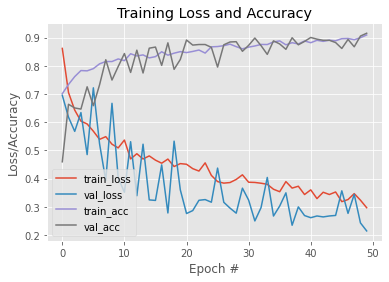

In [15]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=config.BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=config.CLASSES))

# serialize the model to disk
print("[INFO] serializing network to '{}'...".format(config.MODEL_PATH))
model.save(config.MODEL_PATH)

# construct a plot that plots and saves the training history
N = np.arange(0, config.NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(config.TRAINING_PLOT_PATH)

### Making predictions on fire/non-fire images

In [16]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model(config.MODEL_PATH)

[INFO] loading model...


In [17]:
# grab the paths to the fire and non-fire images, respectively
print("[INFO] predicting...")
firePaths = list(paths.list_images(config.FIRE_PATH))
nonFirePaths = list(paths.list_images(config.NON_FIRE_PATH))

# combine the two image path lists, randomly shuffle them, and sample
# them
imagePaths = firePaths + nonFirePaths
random.shuffle(imagePaths)
imagePaths = imagePaths[:config.SAMPLE_SIZE]

[INFO] predicting...


In [18]:
# loop over the sampled image paths
for (i, imagePath) in enumerate(imagePaths):
	# load the image and clone it
	image = cv2.imread(imagePath)
	output = image.copy()

	# resize the input image to be a fixed 128x128 pixels, ignoring
	# aspect ratio
	image = cv2.resize(image, (128, 128))
	image = image.astype("float32") / 255.0
		
	# make predictions on the image
	preds = model.predict(np.expand_dims(image, axis=0))[0]
	j = np.argmax(preds)
	label = config.CLASSES[j]

	# draw the activity on the output frame
	text = label if label == "Non-Fire" else "WARNING! Fire!"
	output = imutils.resize(output, width=500)
	cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
		1.25, (0, 255, 0), 5)

	# write the output image to disk	 
	filename = "{}.png".format(i)
	p = os.path.sep.join([config.OUTPUT_IMAGE_PATH, filename])
	cv2.imwrite(p, output)